In [29]:
import pymc3 as pm
import arviz as az
import theano.tensor as tt
import numpy as np
import matplotlib.pyplot as plt
import cdms2 as cdms
import MV2 as mv
import sys, os, glob
import cdutil,cdtime,genutil
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
from pymc3.distributions import Interpolated
from scipy import stats
import xarray as xr
import scipy.special as special
#Impose uniform color scheme
def get_colors(forcing):
    colors={}
    colors["GHG"]=cm.tab10(2)
    colors["aer"]=cm.tab10(1)
    colors["nat"]=cm.tab10(3)
    colors["historical"]="k"
    colors["other"]=cm.tab10(4)
    colors["obs"]=cm.tab10(0)
    return colors[forcing]

## Function to turn posterior density into prior 
##(from https://docs.pymc.io/en/v3/pymc-examples/examples/pymc3_howto/updating_priors.html)
def from_posterior(param, samples):
    smin, smax = np.min(samples), np.max(samples)
    width = smax - smin
    x = np.linspace(smin, smax, 100)
    y = stats.gaussian_kde(samples)(x)

    # what was never sampled should have a small probability but not 0,
    # so we'll extend the domain and use linear approximation of density on it
    x = np.concatenate([[x[0] - 3 * width], x, [x[-1] + 3 * width]])
    y = np.concatenate([[0], y, [0]])
    return Interpolated(param, x, y)

# Specify the base period

In [30]:
base_start=1900
base_stop=1950
base_period=(str(base_start)+"-1-1",str(base_stop)+"-1-1")

Read in GISTEMP data

In [3]:
df=pd.read_csv("https://data.giss.nasa.gov/gistemp/tabledata_v4/GLB.Ts+dSST.csv",skiprows=[0])


In [4]:
allyears=df["Year"].values[:-1]
dat=df["J-D"].values[:-1].astype(float)
y=allyears[:int(np.where(allyears==2015)[0])]
gistemp=dat[:int(np.where(allyears==2015)[0])]

istart=int(np.where(allyears==base_start)[0])
istop=int(np.where(allyears==base_stop)[0])

gistemp_clim=np.average(gistemp[istart:istop+1])
gistemp=gistemp-gistemp_clim


# Read in in GISS data 

In [5]:
annual=True
if annual:
    func=lambda x: cdutil.YEAR(x)
    
else:
    func = lambda x:x
#Read in the simulation data
direc="../GISS_SINGLE_FORCING/"

GISS_simulations={}
for experiment in [x.split(".nc")[0] for x in os.listdir(direc)]:
    
    f=cdms.open(direc+experiment+".nc")
    try:
        ensemble=f("tas")#(time=("1880-1-1","2014-12-31"))
    except:
        ensemble=f('variable_12842')#(time=("1880-1-1","2014-12-31")) #kludge: forgot to label the piControl global mean anomalies as tas
    f.close()
    if experiment != "piControl":
        
        data=func(ensemble)(time=("1880-1-1","2014-12-31"))
        climatology=np.average(data(time=base_period))
        GISS_simulations[experiment]=data-climatology
    else:
        GISS_simulations[experiment]=func(ensemble)
        
#split picontrol into chunks
nmembers,nt=GISS_simulations["historical"].shape
t=np.arange(nt)+1850
piC=GISS_simulations["piControl"]
nt_piC=len(piC)
nchunks=int(nt_piC/nt)
piC_ensemble=piC[:nchunks*nt].reshape(nchunks,nt)
GISS_simulations["piControl"]=piC_ensemble
GISS_simulations["piControl_concatenated"]=piC

In [6]:
#Learning the forced signal from observations, no models
with pm.Model() as learnmodel:
    μ=pm.Normal("μ",0,10,shape=nt)
    σ=pm.HalfNormal("σ",10)
    obs=pm.Normal("obs",mu=μ,sigma=σ,observed=gistemp)

In [7]:
with learnmodel:
    learntrace=pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6250037676206851, but should be close to 0.8. Try to increase the number of tuning steps.
There were 170 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4422033139478865, but should be close to 0.8. Try to increase the number of tuning steps.
There were 321 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6796512334430179, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.695814332981812, but should be close to 0.8

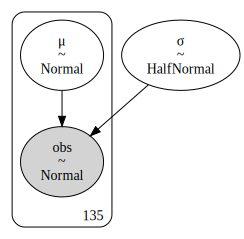

In [8]:
dot=pm.model_graph.model_to_graphviz(learnmodel)
dot
#dot.render(filename="learnmodel",directory='../TALK/',) 

What can we infer about the forced response if we don't assume anything other than white noise?

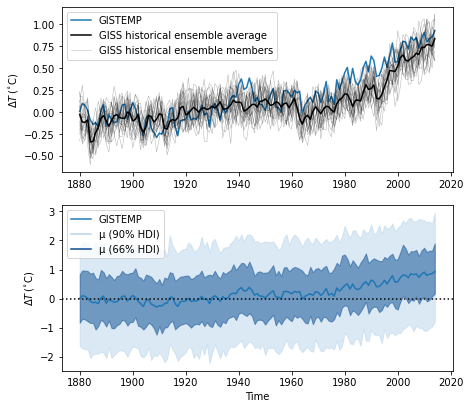

In [9]:
plt.figure(figsize=(7.0,6.7))
plt.subplot(211)
plt.plot(y,gistemp,label="GISTEMP")
plt.ylabel(r"$\Delta T \, (^{\circ}$C)")
plt.plot(y,np.average(GISS_simulations["historical"].asma(),axis=0),c="k",label="GISS historical ensemble average")

plt.plot(y,GISS_simulations["historical"][0].asma(),c="k",lw=.5,alpha=.3,label="GISS historical ensemble members")
tmp=[plt.plot(y,sim.asma(),c="k",lw=.5,alpha=.3) for sim in GISS_simulations["historical"][1:]]
plt.legend()

plt.subplot(212)
az.plot_hdi(y,learntrace.posterior.μ,smooth=False,hdi_prob=.90,color=cm.Blues(.3))

az.plot_hdi(y,learntrace.posterior.μ,smooth=False,hdi_prob=.66,color=cm.Blues(.9))

plt.plot(y,gistemp,label="GISTEMP")
tmp1,=plt.plot([1900],[0],color=cm.Blues(.3),label="μ (90% HDI)")
tmp2,=plt.plot([1900],[0],color=cm.Blues(.9),label="μ (66% HDI)")
plt.legend()
tmp1.set_visible(False)
tmp2.set_visible(False)

plt.axhline(0,c="k",ls=":")
plt.xlabel("Time")
plt.ylabel(r"$\Delta T \, (^{\circ}$C)")

plt.savefig("Figure1.pdf")

In [10]:
y[np.where(az.hdi(learntrace.posterior.μ,hdi_prob=.66).μ[:,0]>0)[0]]

array([2002, 2003, 2007, 2010, 2013, 2014])

# No uncertainty in forced response
Now, suppose the ensemble average of model simulations is the exact searched-for fingerprint:

In [11]:
#Simplest model: suppose we know forcing exactly
with pm.Model() as simplemodel:
    β=pm.Normal("β",0,10)
    σ=pm.HalfNormal("σ",10)
    μ=np.average( GISS_simulations["historical"],axis=0)
    μ_obs=β*μ
    obs=pm.Normal("obs",mu=μ_obs,sigma=σ,observed=gistemp)

In [12]:
with simplemodel:
    simpletrace=pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


<AxesSubplot:title={'center':'x'}>

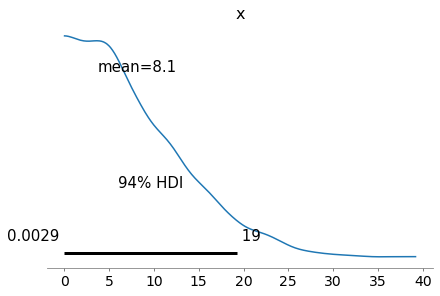

In [13]:
tst=pm.sample_prior_predictive(samples=5000,model=simplemodel,var_names=["β","σ"])
az.plot_posterior(tst["σ"])

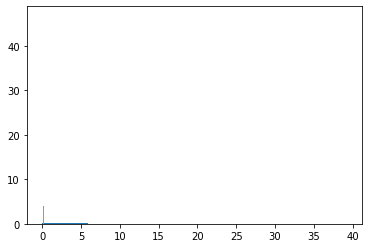

In [14]:
tmp=plt.hist(tst["σ"],100,density=True)
tmp=plt.hist(simpletrace.posterior.σ.values.flatten(),100,density=True)


Posteriors on the scaling factor and internal variability

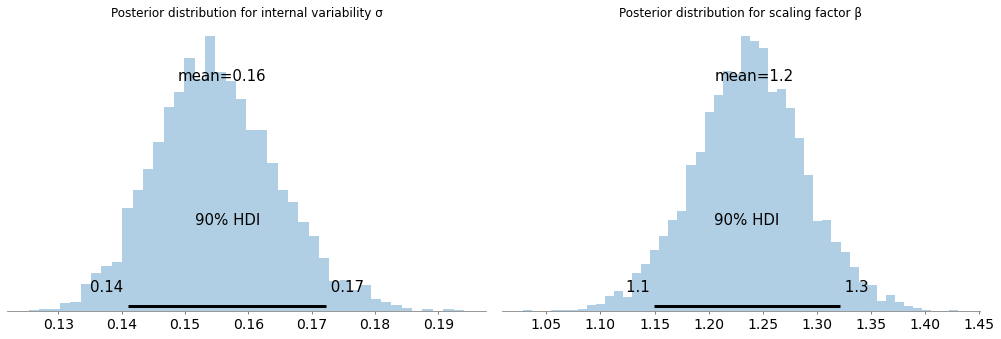

In [15]:
axes=az.plot_posterior(simpletrace,var_names=["σ","β"],kind="hist",hdi_prob=.9)
axes[0].set_title("Posterior distribution for internal variability σ")
axes[1].set_title("Posterior distribution for scaling factor β")
#az.plot_posterior(tst["σ"],ax=axes[0])
plt.savefig("../BayesDA/FIGS/Figure2.pdf")

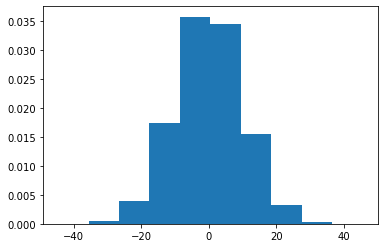

In [16]:
tmp=plt.hist(np.random.normal(0,10,100000),density=True)

# Incorporating piControl information
 First, we use chunks of piControl to train the noise model, fitting posteriors to $\sigma$.

Text(0, 0.5, '$\\Delta T \\, (^{\\circ}$C)')

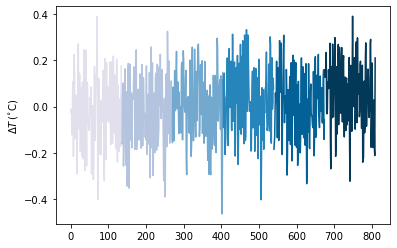

In [17]:
nenspic,ntpic=GISS_simulations["piControl"].shape
for i in range(nenspic):
    timeax=np.arange(ntpic)+i*ntpic
    plt.plot(timeax,GISS_simulations["piControl"][i].asma(),color=cm.PuBu(float(i+1)/nenspic))
plt.ylabel(r"$\Delta T \, (^{\circ}$C)")

In [18]:
#Use posteriors from model ensemble as priors for obs noise
with pm.Model() as piCmodel:
    σ=pm.HalfNormal("σ",10)
    cov=tt.pow(σ,2)*np.eye(nt)
    F=pm.MvNormal("likelihood_piC",mu=np.zeros(nt),cov=cov,\
                             observed= GISS_simulations["piControl"])

#This is a hack: need inferencedata object for az.compare, but I can't figure out how to make from_posterior() function work with inferencedata object.  Fix.
with piCmodel:
    piC_white_trace=pm.sample(return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.


### PiControl and historical data with uncertainty


In [19]:
# Priors from piControl?
with pm.Model() as histmodel_piC:
    β=pm.Normal("β",0,10)
    γ=pm.HalfNormal("γ",10)
    σ=from_posterior("σ",piC_white_trace["σ"])
    cov=tt.pow(γ*σ,2)*np.eye(nt)
    
    μ=pm.Normal("μ",0,10,shape=nt)
    #uncertain model forced response
    F=pm.MvNormal("F",mu=μ,cov=tt.pow(σ,2)*np.eye(nt),observed = GISS_simulations["historical"])
    μ_obs=β*μ
    obs=pm.MvNormal("obs",mu=μ_obs,cov=cov,observed=gistemp)

# Compare noise-only and forced response models

Why does white noise model have the correct log-likelihood shape (nsamp x nt) but red noise model has the wrong shape?

In [20]:
# use piControl simultaneously
with pm.Model() as simul_piC_white_model:
    #Priors
    β=pm.Normal("β",0,10)
    γ=pm.HalfNormal("γ",10)
    
    σGCM = pm.HalfNormal("σGCM",10)
    μ=pm.Normal("μ",0,10,shape=nt)
    
    #Train sigma gcm and mu on historical and piC
    F=pm.Normal("F",mu=μ,sigma=σGCM,\
                observed = GISS_simulations["historical"])
    piC=pm.Normal("likelihood_piC",mu=np.zeros(nt),sigma=σGCM,\
                             observed= GISS_simulations["piControl"])
    μ_obs=β*μ
    σ_obs=γ*σGCM
    obs=pm.Normal("obs",mu=μ_obs,sigma=σ_obs,observed=gistemp,shape=nt)
with simul_piC_white_model:
    whitetrace_withforcing=pm.sample(return_inferencedata=True)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σGCM, γ, β]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.


In [21]:
with pm.Model() as whitemodel:
    σ= pm.HalfNormal("σGCM",10)
    obs=pm.Normal("obs",mu=np.zeros(nt),sigma=σ,observed=gistemp)
with whitemodel:
    whitetrace=pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σGCM]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.
The acceptance probability does not match the target. It is 0.8859689045780994, but should be close to 0.8. Try to increase the number of tuning steps.


In [22]:
with pm.Model() as redmodel:
    coefs = pm.Normal("coefs", 0,10)
    σ= pm.HalfNormal("σ",10)
    obs=pm.AR("obs",coefs,constant=False,sigma=σ,observed=gistemp,shape=nt)
with redmodel:
    redtrace=pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, coefs]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.8787680823616949, but should be close to 0.8. Try to increase the number of tuning steps.


In [31]:
Fmean_ar1=trace_hist_pic_ar1.posterior.μ.mean(dim=("chain","draw"))
sigmean_ar1=float(trace_hist_pic_ar1.posterior.σ.mean().values)
betamean_ar1=float(trace_hist_pic_ar1.posterior.β.mean().values)
phimean_ar1=float(getattr(trace_hist_pic_ar1.posterior,"ϕ").mean().values)

NameError: name 'trace_hist_pic_ar1' is not defined

In [32]:
δ=np.arange(nt)
imj=np.abs(np.subtract.outer(δ,δ))
cov_ar1=sigmean_ar1**2/(1-phimean_ar1**2)*phimean_ar1**imj
covinv_ar1=np.linalg.inv(cov_ar1)

NameError: name 'sigmean_ar1' is not defined

In [ ]:
Fmean_red=trace_hist_pic_ar1.posterior.μ.mean(dim=("chain","draw"))
sigmean_red=float(trace_hist_pic_white.posterior.σ.mean().values)
betamean=float(trace_hist_pic_white.posterior.β.mean().values)

In [ ]:
np.linalg.det(sigmean**2*np.identity(nt))

In [ ]:
tst=1
for i in np.arange(-100,100,.1):
    tst=tst*stats.norm.pdf(i,0,1)


In [ ]:
cov = sigmean**2*np.identity(nt)
covinv=np.linalg.inv(cov)
Mahalanobis=np.dot(np.dot((gistemp-Fmean).T,covinv),(gistemp-Fmean))
Mahalanobis_ar1=np.dot(np.dot((gistemp-Fmean_ar1).T,covinv_ar1),(gistemp-Fmean_ar1))
print(Mahalanobis)
print(Mahalanobis_ar1)

In [ ]:
i=0
tst=stats.norm.pdf(gistemp[i],loc=F[i],scale=sigmean)
for i in range(nt)[1:]:
    tst=tst*stats.norm.pdf(gistemp[i],loc=F[i],scale=sigmean)
np.log(tst)

In [ ]:
# WHAT DO LOG LIKELIHOODS ACTUALLY MEAN?
from scipy.stats import multivariate_normal
#x = np.linspace(0, 5, 10, endpoint=False)
cov = sigmean**2*np.identity(nt)
np.log(multivariate_normal.pdf(gistemp,mean=betamean*F,cov=cov))
#y = multivariate_normal.pdf(x, mean=2.5, cov=0.5)
#plt.plot(x,y)

In [ ]:

tmp=plt.hist(trace_hist_pic_ar1.log_likelihood.obs.values.flatten(),color="r",label="AR(1) + forcing")
tmp=plt.hist(trace_hist_pic_white.log_likelihood.obs.values.flatten(),color="k",label="White noise+forcing")
#tmp=plt.hist(whitetrace.log_likelihood.obs.values.flatten(),color="b",label="White noise")
plt.legend()

In [ ]:
az.waic(trace_hist_pic_white)

In [ ]:
az.plot_trace(trace_hist_pic_white,var_names=["σ"])

In [ ]:
white_ppc["obs"].shape

In [ ]:
az.plot_posterior(redtrace)

In [ ]:
BIGTRACES={"white noise":whitetrace,"white noise with forcing":whitetrace_withforcing,"red noise":redtrace}
for k in BIGTRACES.keys():
    BIGTRACES[k].sample_stats["log_likelihood"]= BIGTRACES[k].log_likelihood.obs

In [ ]:
pm.compare(BIGTRACES)

In [ ]:
az.loo(whitetrace,var_name="obs")

In [ ]:
az.loo(whitetrace_withforcing,var_name="obs")

In [ ]:
with pm.Model() as just_AR1:
    ϕ=pm.Normal("ϕ",0,10)
    σ_obs = pm.HalfNormal("σ_obs",10)
    obs=pm.AR1("obs",k=ϕ,tau_e=1/tt.pow(σ_obs,2),observed=gistemp,shape=nt)

In [ ]:
with just_AR1:
    test_just_AR1=pm.sample(return_inferencedata=True)

In [ ]:
with pm.Model() as simul_piC_AR1_model:
    #Priors
    β=pm.Normal("β",0,10)
    γ=pm.HalfNormal("γ",10)
    ϕ=pm.Normal("ϕ",0,2)
    
    σGCM = pm.HalfNormal("σGCM",10)
    μ=pm.Normal("μ",0,10,shape=nt)
    
    #Train sigma gcm and mu on historical and piC
    F=pm.AR1("F",k=ϕ,tau_e=1/tt.pow(σGCM,2),observed = tt.sub(GISS_simulations["historical"],μ))
    piC=pm.AR1("likelihood_piC",k=ϕ,tau_e=1/tt.pow(σGCM,2),\
                             observed= GISS_simulations["piControl"])
    μ_obs=β*μ
    σ_obs=γ*σGCM
    obs=pm.AR1("obs",k=ϕ,tau_e=1/tt.pow(σ_obs,2),observed=tt.sub(gistemp,μ_obs))


In [ ]:
az.loo(test_loo,var_name="obs")

In [ ]:
with simul_piC_AR1_model:
    test=pm.sample(return_inferencedata=True)

In [ ]:
az.plot_posterior(test,var_names=["γ"])

In [ ]:
with simul_piC_white_model:
    test_loo=pm.sample(return_inferencedata=True)

In [ ]:
#Why is test_loo
az.loo(test_loo,var_name="obs")

In [ ]:
    

# use piControl simultaneously
with pm.Model() as simul_piC_ar1_model:
    β=pm.Normal("β",0,10)
    γ=pm.HalfNormal("γ",10)
    σGCM = pm.HalfNormal("σGCM",10)
    μ=pm.Normal("μ",0,10,shape=nt)
    F=pm.Normal("F",mu=μ,sigma=σGCM,\
                observed = GISS_simulations["historical"])
    piC=pm.Normal("likelihood_piC",mu=np.zeros(nt),sigma=σGCM,\
                             observed= GISS_simulations["piControl"])
    μ_obs=β*μ
    σ_obs=γ*σGCM
    obs=pm.Normal("obs",mu=μ_obs,sigma=σ_obs,observed=gistemp)

In [ ]:
# Is there evidence for nonstationarity of noise???
with pm.Model() as nonstationary_model:
 
    γ=pm.HalfNormal("γ",10)
    σpiC = pm.HalfNormal("σpiC",10)
    μ=pm.Normal("μ",0,10,shape=nt)
    F=pm.Normal("F",mu=μ,sigma=σpiC*γ,\
                observed = GISS_simulations["historical"])
    piC=pm.Normal("likelihood_piC",mu=np.zeros(nt),sigma=σpiC,\
                             observed= GISS_simulations["piControl"])

    

In [ ]:
with nonstationary_model:
    nonstationary_trace = pm.sample(return_inferencedata=True)

In [ ]:
sns.kdeplot(nonstationary_trace.posterior.γ.values.flatten())
plt.axvline(1)

In [ ]:
with histmodel_piC:
    trace_hist_pic_white=pm.sample(return_inferencedata=True)

In [ ]:
plt.figure(figsize=(10,8))
plt.subplot(221)
for i in range(nenspic):
    timeax=np.arange(ntpic)+i*ntpic
    plt.plot(timeax,GISS_simulations["piControl"][i].asma(),color=cm.Purples(float(i+1)/nenspic))
plt.ylabel(r"$\Delta T \, (^{\circ}$C)")
plt.title("(a): Preindustrial control segments")
plt.xlabel("Year")

plt.subplot(223)
sns.kdeplot(piC_white_trace["σ"].flatten(),label="σGCM (piControl)",c=cm.gray(.5))
sns.kdeplot(trace_hist_pic_white.posterior.σ.values.flatten(),\
            label="σGCM (piControl and historical)",c=cm.gray(.01))
sns.kdeplot(simpletrace.posterior.σ.values.flatten(),label=" σobs (No fingerprint uncertainty)",c=cm.Blues(.5))

sns.kdeplot(trace_hist_pic_white.posterior.σ.values.flatten()*\
            trace_hist_pic_white.posterior.γ.values.flatten(),\
            label="σobs (fingerprint uncertainty)",c=cm.Blues(.99))
plt.legend(fontsize=8)
plt.xlabel("σ")
plt.title("(c): Posteriors: modeled/observed internal variability")

plt.subplot(222)

fac=stats.norm.interval(.9)[1]
sigma_ens=np.std(GISS_simulations["historical"],axis=0)
mu_ens=np.average(GISS_simulations["historical"],axis=0)
plt.fill_between(y,mu_ens-fac*sigma_ens,mu_ens+fac*sigma_ens,alpha=.4,label="90% interval estimated from ensemble")


az.plot_hdi(y,trace_hist_pic_white.posterior.μ,smooth=False,color="k",hdi_prob=.9)

tmp,=plt.plot([1900],[0],c="k",alpha=.5,label="F (90% HDI)")
plt.legend()            
tmp.set_visible(False)
plt.title("(b): Forced response")
plt.xlabel("Year")
plt.ylabel(r"$\Delta T \, (^{\circ}$C)")

plt.subplot(224)
sns.kdeplot(simpletrace.posterior.β.values.flatten(),label="β (No fingerprint uncertainty)",c=cm.Blues(.5))
sns.kdeplot(trace_hist_pic_white.posterior.β.values.flatten(),\
            label="β (Fingerprint uncertainty)",c=cm.Blues(.99))
plt.legend(fontsize=8)
plt.title("(d): Posteriors: scaling factor")
plt.tight_layout()
plt.savefig("../BayesDA/FIGS/Figure3.pdf")

In [ ]:

plt.title("Forced response (90% HDI)")
fac=stats.norm.interval(.9)[1]
sigma_ens=np.std(GISS_simulations["historical"],axis=0)
mu_ens=np.average(GISS_simulations["historical"],axis=0)
plt.fill_between(y,mu_ens-fac*sigma_ens,mu_ens+fac*sigma_ens,alpha=.4)
az.plot_hdi(y,trace_hist_pic_white.posterior.μ,smooth=False,hdi_prob=.9,color="k")
plt.ylabel("ΔT")

In [ ]:
axes=az.plot_posterior(trace_hist_pic_white.posterior.β,hdi_prob=.9)
az.plot_posterior(simpletrace.posterior.β,hdi_prob=.9,ax=axes,color="r")

In [ ]:

print(az.hdi(trace_hist_pic_white.posterior.β,hdi_prob=.9).β.values)
print(az.hdi(simpletrace.posterior.β,hdi_prob=.9).β.values)

In [ ]:
# Taking into account the uncertainty in the fingerprint actually 

In [ ]:
sns.kdeplot(simpletrace.posterior.σ.values.flatten(),label="σobs (No fingerprint uncertainty)")
sns.kdeplot(np.sqrt(trace_hist_pic_white.posterior.γ.values.flatten())*\
            trace_hist_pic_white.posterior.σ.values.flatten(),label="Fingerprint uncertainty")
sns.kdeplot(trace_hist_pic_white.posterior.σ.values.flatten(),label="σGCM")
plt.legend()

Posteriors for all other parameters: scaling parameters $\beta$ for (uncertain) external forcing and $\gamma$ for internal variability and internal variability $\sigma$ itself  (as simulated by the model)

In [ ]:
az.plot_posterior(trace_hist_pic_white.posterior,var_names=["σ","γ","β"],hdi_prob=.9)

In [ ]:
az.plot_hdi(y,trace_hist_pic_white.posterior.β*trace_hist_pic_white.posterior.μ,smooth=False,hdi_prob=.99)
plt.plot(y,gistemp)
plt.ylabel("ΔT")
plt.title("Attributed forced component (90% HDI)")

## Alternate noise models
The simple white noise model for internal variability in the observations is not necessarily applicable to some (perhaps most) climate data.  Fortunately, the Bayesian framework can easily accommodate more complex noise models by parameterizing the temporal structure of the covariance matrix.  For example, the covariance matrix of an short memory AR(1) process can be written as 
\begin{equation}
    U_{ij}^{AR(1)} = \frac{\sigma^2}{1-\phi^2} \phi^{|i-j|}.
\end{equation}
A long-memory process can be modeled using a fractionally differenced process with covariance matrix
\begin{equation}
U_{ij}^{FD} =\frac{\sigma^2 \sin(\pi \delta) \Gamma((1-2\delta) \Gamma(|i-j| + \delta)}{\pi \Gamma(|i-j|+ 1-\delta}
\end{equation}
In both cases, the additional structure added to the covariance matrix results in only one additional parameter to be estimated.  

Let's do AR(1) noise here

In [ ]:
with pm.Model() as piC_AR1:
    σ=pm.HalfNormal("σ",10)
    ϕ=pm.Uniform("ϕ",-1,1)
    #AR(1) covariance matrix
    δ=np.arange(nt)
    imj=np.abs(np.subtract.outer(δ,δ))
    cov=tt.pow(σ,2)/(1-tt.pow(ϕ,2))*tt.pow(ϕ,imj)
    
    chol=tt.slinalg.cholesky(cov)
    
    
    #use piControl to train the noise model

    F=pm.MvNormal("likelihood_piC",mu=np.zeros(nt),chol=chol,\
                             observed= GISS_simulations["piControl"])


In [ ]:
with pm.Model() as piC_long_memory:
    σ=pm.HalfNormal("σ",10)
    δ=pm.Uniform("δ",0,.5)
    D=np.arange(nt)
    imj=np.abs(np.subtract.outer(D,D))
    cov= (tt.pow(σ,2) * tt.sin(np.pi*δ)* tt.gamma(1-2*δ) * tt.gamma(imj+δ))/(np.pi*tt.gamma(imj+1-δ))
    chol=tt.slinalg.cholesky(cov)
    
    
    #use piControl to train the noise model

    F=pm.MvNormal("likelihood_piC",mu=np.zeros(nt),chol=chol,\
                             observed= GISS_simulations["piControl"])


In [ ]:
with piC_long_memory:
    piC_long_trace_inference=pm.sample(return_inferencedata=True)

In [ ]:
with piC_AR1:
    piC_AR1_trace=pm.sample(return_inferencedata=True)

In [ ]:
az.plot_posterior(piC_AR1_trace,var_names=["ϕ"])

In [ ]:
sns.kdeplot(getattr(RED_NOISE_PLUS_FORCED_RESPONSE_TRACE.posterior,"ϕ").values.flatten())
sns.kdeplot(getattr(RED_NOISE_ONLY_TRACE.posterior,"ϕ").values.flatten())
sns.kdeplot(getattr(piC_AR1_trace.posterior,"ϕ").values.flatten())

In [ ]:
#Inferencedata objects for both noise models for use by az.compare
with piC_AR1:
    piC_AR1_inference=pm.sample(return_inferencedata=True)
with piCmodel:
    piC_white_inference=pm.sample(return_inferencedata=True)

In [ ]:
az.plot_posterior(piC_AR1_inference.posterior,var_names=["ϕ","σ"])

### Which noise model is better?
Compare models based on their expected log pointwise predictive density (ELPD).

The ELPD is estimated either by Pareto smoothed importance sampling leave-one-out cross-validation (LOO) dx.doi.org/10.1111/1467-9868.00353

In [ ]:
az.loo(piC_AR1_inference)

In [ ]:
dfcomp=az.compare({"AR(1) noise model":piC_AR1_inference,"Gaussian noise model":piC_white_inference,"long": piC_long_trace_inference})

In [ ]:
dfcomp

In [ ]:
dfcomp[["rank","loo","p_loo","se"]].to_latex("noisecomptable.tex")

posteriors for AR(1) red noise model

In [ ]:
az.plot_posterior(piC_AR1_trace,var_names=["σ","ϕ"],hdi_prob=.9,kind="hist",color="k")

## Uncertain historical forced response, AR(1) noise

In [ ]:
with pm.Model() as piC_AR1_hist:

    σ=from_posterior("σ",piC_AR1_trace["σ"])
    ϕ=from_posterior("ϕ",piC_AR1_trace["ϕ"])
    #observed scaling factors
    β=pm.Normal("β",0,10)
    γ=pm.HalfNormal("γ",10)
   
    #assume the autocorrelation in the obs is the same as that in the models
    
    
    
    #AR(1) covariance matrix
    δ=np.arange(nt)
    imj=np.abs(np.subtract.outer(δ,δ))
    cov=tt.pow(σ,2)/(1-tt.pow(ϕ,2))*tt.pow(ϕ,imj)

    chol=tt.slinalg.cholesky(cov)
    
    covobs=tt.pow(γ*σ,2)/(1-tt.pow(ϕ,2))*tt.pow(ϕ,imj)

    chol_obs=tt.slinalg.cholesky(covobs)
    
    μ=pm.Normal("μ",0,10,shape=nt)
    
    F=pm.MvNormal("likelihood_hist",mu=μ,chol=chol,\
                             observed= GISS_simulations["historical"])
    μ_obs=β*μ
    obs=pm.MvNormal("obs",mu=μ_obs,chol=chol_obs,observed=gistemp)
 


In [ ]:
with piC_AR1_hist:
    
    trace_hist_pic_ar1=pm.sample(return_inferencedata=True)

In [ ]:
with pm.Model() as just_noise:
    #Coefficients of forced responses
    
    
    #Internal variability
    σ=pm.HalfNormal("σ",10)
    
    obs=pm.MvNormal("obs",mu=np.zeros(nt),cov=tt.pow(σ,2)*np.identity(nt),observed=gistemp,)

with just_noise:
    trace_just_noise=pm.sample(return_inferencedata=True)

In [ ]:
with pm.Model() as AR1_justnoise:
    
    #observed scaling factors
    #β=pm.Normal("β",0,10)
    σ=pm.HalfNormal("γ",10)
    ϕ=pm.Uniform("ϕ",-1,1)
    covobs=tt.pow(σ,2)/(1-tt.pow(ϕ,2))*tt.pow(ϕ,imj)

    chol_obs=tt.slinalg.cholesky(covobs)
    μ_obs=np.zeros(nt)
    obs=pm.MvNormal("obs",mu=μ_obs,chol=chol_obs,observed=gistemp)
with AR1_justnoise:
    trace_just_AR1=pm.sample(return_inferencedata=True)

In [ ]:
test=pm.sample_posterior_predictive(trace_just_AR1,model=AR1_justnoise,var_names=["obs"])

In [ ]:
sns.kdeplot(trace_hist_pic_ar1.posterior.β.values.flatten())
sns.kdeplot(trace_hist_pic_white.posterior.β.values.flatten())

In [ ]:
tmp=[plt.plot(y,samp,"k",lw=.5,alpha=.2) for samp in test["obs"]]
plt.plot(y,gistemp)

In [ ]:
DA_TRACES={"Gaussian noise, forced response":trace_hist_pic_white,\
           "AR(1) noise, forced response":trace_hist_pic_ar1}#,\
          #"Gaussian noise, no forced response": trace_just_noise,
         # "AR(1) noise, no forced response":trace_just_AR1}

In [ ]:
for k in DA_TRACES.keys():
    DA_TRACES[k].sample_stats["log_likelihood"]=DA_TRACES[k].log_likelihood.obs

In [ ]:
az.compare(DA_TRACES)

In [ ]:
plt.figure(figsize=(10,8))
sns.kdeplot(simpletrace.posterior.β.values.flatten(),label="No fingerprint uncertainty")
sns.kdeplot(trace_hist_pic_white.posterior.β.values.flatten(),label="Fingerprint hierarchy, Gaussian internal variability)")
sns.kdeplot(trace_hist_pic_ar1.posterior.β.values.flatten(),label="Fingerprint hierarchy, AR(1) internal variability)")
plt.legend(loc=4)
plt.xlabel("β")

In [ ]:
HISTORICALTRACES={"Gaussian noise"}

In [ ]:
az.plot_posterior(picar1histtrace,var_names=["β","γ","σ","ϕ"])

## Multiple external forcings
Use DAMIP ensembles of single-forcing simulations

In [ ]:
#Multiple external forcings
external_forcings = ["aer","GHG","nat"]

with pm.Model() as allforcingsmodel:
    #Coefficients of forced responses
    β={}
    #Latent true forced responses
    μ={}
    for forcing in external_forcings:
        β[forcing]=pm.Normal("β"+forcing,0,10)
        μ[forcing]=pm.Normal("μ"+forcing,0,10,shape=nt)
    β["other"]=pm.Normal("βother",0,10)
    μ["other"]=pm.Normal("μother",0,10,shape=nt)
    
    #Internal variability
    σ=pm.HalfNormal("σ",10)
    σmod=pm.HalfNormal("σmod",10)
    
    #uncertain model forced responses
    F={}
    for forcing in external_forcings:
        F[forcing]=pm.Normal("F"+forcing,mu=μ[forcing],sigma=σmod,shape=nt,\
                             observed = GISS_simulations["hist-"+forcing])
    μ_historical = μ["other"]
    for forcing in external_forcings:
        μ_historical += μ[forcing]
    Fhistorical = pm.Normal("Fhistorical",mu = μ_historical,sigma=σmod,shape=nt, \
                            observed=GISS_simulations["historical"])
    

    
    #Observed mean
    μ_obs= β["other"]*μ["other"]
    for forcing in external_forcings:
        μ_obs += β[forcing]*μ[forcing]
    
    obs=pm.Normal("obs",mu=μ_obs,sigma=σ,observed=gistemp)

In [ ]:
with allforcingsmodel:
    allforcingstrace=pm.sample(return_inferencedata=True)

In [ ]:
scaled={}
for forcing in ["nat","aer","GHG","other"]:
    scaled[forcing]=getattr(allforcingstrace.posterior,"μ"+forcing)\
    *getattr(allforcingstrace.posterior,"β"+forcing)

import matplotlib.gridspec as gridspec

fig=plt.figure(figsize=(10,8))
gs=fig.add_gridspec(2,2)
f1=fig.add_subplot(gs[0,0])
plt.title("(a): Fingerprints (90% HDI)")
az.plot_hdi(y,allforcingstrace.posterior.μGHG,smooth=False,color=cm.tab10(2),hdi_prob=.9)
az.plot_hdi(y,allforcingstrace.posterior.μaer,smooth=False,color=cm.tab10(1),hdi_prob=.9)
az.plot_hdi(y,allforcingstrace.posterior.μnat,smooth=False,color=cm.tab10(3),hdi_prob=.9)
az.plot_hdi(y,allforcingstrace.posterior.μother,smooth=False,color=cm.tab10(4),hdi_prob=.9)
plt.axhline(0,ls=":",c="k")
plt.legend()
plt.ylabel("ΔT")

f2=fig.add_subplot(gs[0,1])
plt.title("(b): Scaling factors")
sns.kdeplot(allforcingstrace.posterior.βGHG.values.flatten(),color=cm.tab10(2),label="GHG")
sns.kdeplot(allforcingstrace.posterior.βaer.values.flatten(),color=cm.tab10(1),label="Aerosol")
sns.kdeplot(allforcingstrace.posterior.βnat.values.flatten(),color=cm.tab10(3),label="Natural forcings")
sns.kdeplot(allforcingstrace.posterior.βother.values.flatten(),color=cm.tab10(4),label="Other")
plt.xlabel("β")
plt.legend()

f3=fig.add_subplot(gs[1,:])
bottom_neg=np.zeros(nt)
bottom_pos=np.zeros(nt)
bottom=np.zeros(nt)
for forcing in ["nat","aer","GHG","other"]:
    toplot=np.median(scaled[forcing],axis=[0,1])
    bottom=np.where(toplot<0,bottom_neg,bottom_pos)
    plt.bar(y,toplot,color=get_colors(forcing),bottom=bottom,alpha=.6,label=forcing)
    
    bottom_neg=np.where(toplot<0,toplot,bottom_neg)
    bottom_pos=np.where(toplot>0,toplot,bottom_pos)
plt.plot(y,gistemp,lw=3,label="GISTEMP")
plt.legend()
plt.title("(c): Contributions to observed temperature (posterior mean)")

plt.tight_layout()
plt.savefig("../BayesDA/FIGS/Figure4.pdf")

In [ ]:
az.plot_hdi(y,allforcingstrace.posterior.μother,color=cm.tab10(4),hdi_prob=.1,smooth=True)

In [ ]:
100*(az.hdi(scaled["aer"],hdi_prob=.9).x.values[-1]/gistemp[-1])

Plot the highest posterior density interval (90%) for all forced responses estimated from DAMIP ensembles

In [ ]:
az.plot_hdi(y,allforcingstrace.posterior.μGHG,smooth=False,color=cm.tab10(2),hdi_prob=.9)
az.plot_hdi(y,allforcingstrace.posterior.μaer,smooth=False,color=cm.tab10(1),hdi_prob=.9)
az.plot_hdi(y,allforcingstrace.posterior.μnat,smooth=False,color=cm.tab10(3),hdi_prob=.9)
az.plot_hdi(y,allforcingstrace.posterior.μother,smooth=False,color=cm.tab10(4),hdi_prob=.9)
plt.axhline(0,ls=":",c="k")
plt.ylabel("ΔT")

Scaling factors for each external forcing

In [ ]:
sns.kdeplot(allforcingstrace.posterior.βGHG.values.flatten(),color=cm.tab10(2),label="GHG")
sns.kdeplot(allforcingstrace.posterior.βaer.values.flatten(),color=cm.tab10(1),label="Aerosol")
sns.kdeplot(allforcingstrace.posterior.βnat.values.flatten(),color=cm.tab10(3),label="Natural forcings")
sns.kdeplot(allforcingstrace.posterior.βother.values.flatten(),color=cm.tab10(4),label="Other")
plt.xlabel("β")
plt.legend()

In [ ]:
#Plot forced contributions (posterior median)
plt.figure(figsize=(10,5))
bottom_neg=np.zeros(nt)
bottom_pos=np.zeros(nt)
bottom=np.zeros(nt)
for forcing in ["nat","aer","GHG","other"]:
    toplot=np.median(scaled[forcing],axis=[0,1])
    bottom=np.where(toplot<0,bottom_neg,bottom_pos)
    plt.bar(y,toplot,color=get_colors(forcing),bottom=bottom,alpha=.6,label=forcing)
    
    bottom_neg=np.where(toplot<0,toplot,bottom_neg)
    bottom_pos=np.where(toplot>0,toplot,bottom_pos)
plt.plot(y,gistemp,lw=3,label="GISTEMP")
plt.legend()

Greenhouse gases made 1951-1980 warmer than years previously, and colder than subsequent years.  Aerosols had the reverse effect.  Natural forcings had essentially no impact except in years corresponding to large volcanic eruptions.

In [ ]:

with pm.Model() as allforcingsmodel_noresidual:
    #Coefficients of forced responses
    β={}
    #Latent true forced responses
    μ={}
    for forcing in external_forcings:
        β[forcing]=pm.Normal("β"+forcing,0,10)
        μ[forcing]=pm.Normal("μ"+forcing,0,10,shape=nt)
    
    
    #Internal variability
    σ=pm.HalfNormal("σ",10)
    σmod=pm.HalfNormal("σmod",10)
    
    #uncertain model forced responses
    F={}
    for forcing in external_forcings:
        F[forcing]=pm.Normal("F"+forcing,mu=μ[forcing],sigma=σmod,shape=nt,\
                             observed = GISS_simulations["hist-"+forcing])
    

    
    #Observed mean
    μ_obs=0.
    for forcing in external_forcings:
        μ_obs += β[forcing]*μ[forcing]
    
    obs=pm.Normal("obs",mu=μ_obs,sigma=σ,observed=gistemp)

with allforcingsmodel_noresidual:
    trace_noresidual=pm.sample(return_inferencedata=True)

In [ ]:

with pm.Model() as allforcingsmodel_noaerosol:
    #Coefficients of forced responses
    β={}
    #Latent true forced responses
    μ={}
    for forcing in ["GHG","nat"]:
        β[forcing]=pm.Normal("β"+forcing,0,10)
        μ[forcing]=pm.Normal("μ"+forcing,0,10,shape=nt)
    
    
    #Internal variability
    σ=pm.HalfNormal("σ",10)
    σmod=pm.HalfNormal("σmod",10)
    
    #uncertain model forced responses
    F={}
    for forcing in ["GHG","nat"]:
        F[forcing]=pm.Normal("F"+forcing,mu=μ[forcing],sigma=σmod,shape=nt,\
                             observed = GISS_simulations["hist-"+forcing])
    

    
    #Observed mean
    μ_obs=0.
    for forcing in ["GHG","nat"]:
        μ_obs += β[forcing]*μ[forcing]
    
    obs=pm.Normal("obs",mu=μ_obs,sigma=σ,observed=gistemp)

with allforcingsmodel_noaerosol:
    trace_noaerosol=pm.sample(return_inferencedata=True)

In [ ]:

with pm.Model() as allforcingsmodel_noGHG:
    #Coefficients of forced responses
    β={}
    #Latent true forced responses
    μ={}
    for forcing in ["aer","nat"]:
        β[forcing]=pm.Normal("β"+forcing,0,10)
        μ[forcing]=pm.Normal("μ"+forcing,0,10,shape=nt)
    
    
    #Internal variability
    σ=pm.HalfNormal("σ",10)
    σmod=pm.HalfNormal("σmod",10)
    
    #uncertain model forced responses
    F={}
    for forcing in ["aer","nat"]:
        F[forcing]=pm.Normal("F"+forcing,mu=μ[forcing],sigma=σmod,shape=nt,\
                             observed = GISS_simulations["hist-"+forcing])
    

    
    #Observed mean
    μ_obs=0.
    for forcing in ["aer","nat"]:
        μ_obs += β[forcing]*μ[forcing]
    
    obs=pm.Normal("obs",mu=μ_obs,sigma=σ,observed=gistemp)

with allforcingsmodel_noGHG:
    trace_noGHG=pm.sample(return_inferencedata=True)

In [ ]:
with pm.Model() as just_noise:
    #Coefficients of forced responses
    
    
    #Internal variability
    σ=pm.HalfNormal("σ",10)
    
    obs=pm.Normal("obs",mu=np.zeros(nt),sigma=σ,observed=gistemp)

with just_noise:
    trace_just_noise=pm.sample(return_inferencedata=True)

In [ ]:
with pm.Model() as just_ar1:
    #Coefficients of forced responses
    theta=pm.Normal("theta",0,2)
    
    #Internal variability
    σ=pm.HalfNormal("σ",10)
    
    obs=pm.AR1("obs",k=theta,tau_e=1./tt.pow(σ,2),observed=gistemp)

with just_ar1:
    trace_just_ar1=pm.sample(return_inferencedata=True)

In [ ]:
TRACES={"all":allforcingstrace,"noaer":trace_noaerosol,"noGHG":trace_noGHG,\
        "white noise":trace_just_noise,"noother":trace_noresidual}

In [ ]:
for k in TRACES.keys():
    TRACES[k].sample_stats["log_likelihood"]=TRACES[k].log_likelihood.obs

In [ ]:
az.compare(TRACES)

In [ ]:
az.loo(allforcingstrace,var_name="obs")

In [ ]:
az.loo(trace_noaerosol,var_name="obs")

In [ ]:
az.loo(trace_noGHG,var_name="obs")

In [ ]:
az.loo(trace_noresidual,var_name="obs")

In [ ]:
az.loo(trace_just_noise,var_name="obs")

# Scratchwork

In [ ]:
with pm.Model() as ar1_easy_model:
    rho = pm.Uniform("rho",-1,1,shape=1)
    sigma=pm.HalfNormal("sigma",10,shape=1)
    # process mean
    center = pm.Normal("center", mu=0.0, sigma=10.0,shape=nt)
  



    likelihood = pm.AR1("y", k=rho, tau_e=1./tt.pow(sigma,2), observed=GISS_simulations["historical"].asma()-center)
with ar1_easy_model:
    ar1trace = pm.sample(1000)
    ar1_idata = az.from_pymc3(ar1trace)

In [ ]:
with pm.Model() as Gaussian_easy_model:
    sigma=pm.HalfNormal("sigma",10,shape=1)
    center = pm.Normal("center", mu=0.0, sigma=10.0,shape=nt)
    likelihood = pm.Normal("y", mu=center,sigma=sigma, observed=GISS_simulations["historical"].asma())
with Gaussian_easy_model:
    Gaussiantrace = pm.sample(1000)
    Gaussian_idata = az.from_pymc3(Gaussiantrace)

In [ ]:
az.compare({"white": Gaussian_idata,"ar1":ar1_idata})

In [ ]:
sns.kdeplot(np.sqrt(trace["rho"]).flatten())
#sns.kdeplot(piC_AR1_trace["ϕ"].flatten())

In [ ]:
az.plot_hdi(y,idata.posterior.center,smooth=False,hdi_prob=.99)

# Is there a common forced response across ensemble members?


In [ ]:
experiment="historical"

#prepare the data
forced_ensemble = GISS_simulations[experiment]
nmembers,nt=forced_ensemble.shape
t=np.arange(nt)+1850
piC=GISS_simulations["piControl"]
nt_piC=len(piC)
nchunks=int(nt_piC/nt)
piC_ensemble=piC[:nchunks*nt].reshape(nchunks,nt)



In [ ]:
# Plot of ensemble members 

In [ ]:
tmp=[plt.plot(t,forced_ensemble[i].asma(),"k",alpha=1,lw=.5,c=cm.magma(float(i)/nmembers)) for i in range(nmembers)]
#plt.plot(t,np.average(forced_ensemble.asma(),axis=0),c="k",lw=3)
plt.ylabel("ΔT")

# Fixed Effect 
The individual forced ensemble members $m_i$ reflect a common forced response $\mu$ and internal variability, modeled as white noise:
\begin{equation}
m_i \sim N(\mu,\sigma)
\end{equation}
Moreover, we assume the pre-industrial control simulations $p_i$ have the same internal variability and no forced response:
$$ p_i \sim N(0,\sigma) $$

In [ ]:
with pm.Model() as fixedeffect:
    #Prior on latent forced response
    μ=pm.Normal("μ",np.zeros_like(nt),10,shape=nt)
    #Prior on model-simulated internal variability
    #σ=pm.HalfNormal("σ",10)
    σ=from_posterior("σ",piCtrace["σ"])
    ensemble_likelihood=pm.Normal("ensemble_likelihood",μ,σ,observed=forced_ensemble)
    #piC_likelihood=pm.Normal("piC_likelihood",0,σ,observed=piC_ensemble)
    
with fixedeffect:
    fixedtrace=pm.sample(return_inferencedata=True)

# Random effects 
The individual forced ensemble members $m_i$ reflect a forced response $\theta_i$ and internal variability, modeled as white noise:
$$ m_i \sim N(\theta_i,\sigma) $$
The forced responses in each individual simulation are assumed to be normally distributed around a common response
$$\Theta_i \sim N(\mu,\tau)$$
Moreover, we assume the pre-industrial control simulations $p_i$ have the same internal variability and no forced response:
$$ p_i \sim N(0,\sigma) $$

In [ ]:
#Is there evidence for nonhomogeneity?
with pm.Model() as randomeffect:
    #prior on true common forced response
    μ=pm.Normal("μ",np.zeros_like(nt),10,shape=nt)
    #prior on Inter-ensemble member variation
    τ=pm.HalfNormal("τ",10)
    #Prior on Common internal variability
   # σ = pm.HalfNormal("σ",10)
    σ=from_posterior("σ",piCtrace["σ"])
    #Forced response in each ensemble member
    θ=pm.Normal('θ',μ,sd=τ,shape=forced_ensemble.shape)
    ensemble_likelihood=pm.Normal("ensemble_likelihood",θ,sd=σ,observed=forced_ensemble)
    #piC_likelihood = pm.Normal("piC_likelihood",np.zeros_like(nt),sd=σ,observed=piC_ensemble)

In [ ]:
with randomeffect:
    randomtrace=pm.sample(return_inferencedata=True)

In [ ]:
az.plot_hdi(y,fixedtrace.posterior.μ,smooth=False,hdi_prob=.9)
az.plot_hdi(y,randomtrace.posterior.μ,smooth=False,hdi_prob=.9,color="b")

In [ ]:
#posterior for inter-ensemble spread in forced response
az.plot_posterior(randomtrace.posterior.τ)

In [ ]:
#A higher log-score (or a lower deviance) indicates a model with better predictive accuracy
az.waic(fixedtrace,var_name="ensemble_likelihood")

In [ ]:
az.waic(randomtrace,var_name="ensemble_likelihood")

In [ ]:
#Constitutes (some, weak) evidence for a random effect?
az.compare({"fixed":fixedtrace,"random":randomtrace})

## Volcanic forcing: does it depend on background state?
Restrict forced response to years where we know there was a volcanic eruption

In [ ]:
lower=az.hdi(randomtrace.posterior.μ,hdi_prob=.99).μ[:,0]
upper=az.hdi(randomtrace.posterior.μ,hdi_prob=.99).μ[:,1]
response_present=np.where(np.sign(lower*upper)>0)[0]
t[response_present]

In [ ]:
tmp=[plt.plot(t[response_present],forced_ensemble.asma()[:,response_present][i],"o") for i in range(nmembers)]
plt.ylabel("ΔT")

In [ ]:
pinatubo=response_present[int(np.where(t[response_present]==1991)[0]):]
#prepare the data
forced_ensemble_pinatubo = GISS_simulations[experiment].asma()[:,pinatubo]
nmembers_pinatubo,nt_pinatubo=forced_ensemble_pinatubo.shape


nchunks_pinatubo=int(nt_piC/nt_pinatubo)
piC_ensemble_pinatubo=piC[:nchunks_pinatubo*nt_pinatubo].reshape(nchunks_pinatubo,nt_pinatubo)

In [ ]:
#Is there evidence for nonhomogeneity?
with pm.Model() as randomeffect_pinatubo:
    #prior on true common forced response
    μ=pm.Normal("μ",np.zeros_like(nt_pinatubo),10,shape=nt_pinatubo)
    #prior on Inter-ensemble member variation
    τ=pm.HalfNormal("τ",10)
    #Prior on Common internal variability
    σ = pm.HalfNormal("σ",10)
    #Forced response in each ensemble member
    θ=pm.Normal('θ',μ,sd=τ,shape=forced_ensemble_pinatubo.shape)
    obs=pm.Normal("obs",θ,sd=σ,observed=forced_ensemble_pinatubo)
    piC_likelihood = pm.Normal("piC_likelihood",np.zeros_like(nt_pinatubo),sd=σ,observed=piC_ensemble_pinatubo)

In [ ]:
with randomeffect_pinatubo:
    tracepinatubo=pm.sample(return_inferencedata=True)

In [ ]:
az.plot_posterior(tracepinatubo.posterior.τ,kind="hist")

In [ ]:
az.plot_posterior(tracepinatubo.posterior.σ,kind="hist")

In [ ]:
az.plot_hdi(np.arange(nt_pinatubo)+1991,tracepinatubo.posterior.μ,smooth=False)

# Efficient leave-one-out cross validation for Bayesian non-factorized normal and Student-t models


In [ ]:

def covariance_ar1(sigma,phi,N):
    δ=np.arange(N)
    imj=np.abs(np.subtract.outer(δ,δ))
    cov_ar1=sigma**2/(1-phi**2)*phi**imj
    return cov_ar1

def covariance_FD(σ,δ,N):
    
    D=np.arange(nt)
    imj=np.abs(np.subtract.outer(D,D))
    cov_FD= (σ**2 * np.sin(np.pi*δ)* special.gamma(1-2*δ) * special.gamma(imj+δ))/\
    (np.pi*special.gamma(imj+1-δ))
    return cov_FD
def covariance_Gaussian(sigma,N):
    return sigma**2*np.identity(N)
def pointwise_loglik(y,mui,sigmai):
    return -0.5*np.log(2*np.pi) - 0.5*np.log(sigmai**2) - 0.5*(y-mui)**2/sigmai**2

In [ ]:
with pm.Model() as RED_NOISE_PLUS_FORCING_MODEL:

    σ_GCM=pm.HalfNormal("σ_GCM",10)
    ϕ=pm.Uniform("ϕ",-1,1)
    #observed scaling factors
    β=pm.Normal("β",0,10)
    
    σ_obs=pm.HalfNormal("σ_obs",10)
   
    #assume the autocorrelation in the obs is the same as that in the models
    
    
    
    #AR(1) covariance matrix
    δ=np.arange(nt)
    imj=np.abs(np.subtract.outer(δ,δ))
    cov=tt.pow(σ_GCM,2)/(1-tt.pow(ϕ,2))*tt.pow(ϕ,imj)

    chol=tt.slinalg.cholesky(cov)
    
    covobs=tt.pow(σ_obs,2)/(1-tt.pow(ϕ,2))*tt.pow(ϕ,imj)

    chol_obs=tt.slinalg.cholesky(covobs)
    
    μ=pm.Normal("μ",0,10,shape=nt)
    
    F=pm.MvNormal("likelihood_hist",mu=μ,chol=chol,\
                             observed= GISS_simulations["historical"])
    picontrol=pm.MvNormal("likelihood_piControl",mu=np.zeros(nt),chol=chol,
                         observed=GISS_simulations["piControl"])
    μ_obs=β*μ
    obs=pm.MvNormal("obs",mu=μ_obs,chol=chol_obs,observed=gistemp)

In [ ]:
with pm.Model() as WHITE_NOISE_PLUS_FORCING_MODEL:

    σ_GCM=pm.HalfNormal("σ_GCM",10)
    
    #observed scaling factors
    β=pm.Normal("β",0,10)
    
    σ_obs=pm.HalfNormal("σ_obs",10)
   
    #assume the autocorrelation in the obs is the same as that in the models
    
    
    
    #Gaussian covariance matrix
    
    cov=tt.pow(σ_GCM,2)*np.identity(nt)

    chol=tt.slinalg.cholesky(cov)
    
    covobs=tt.pow(σ_obs,2)*np.identity(nt)

    chol_obs=tt.slinalg.cholesky(covobs)
    
    μ=pm.Normal("μ",0,10,shape=nt)
    
    F=pm.MvNormal("likelihood_hist",mu=μ,chol=chol,\
                             observed= GISS_simulations["historical"])
    picontrol=pm.MvNormal("likelihood_piControl",mu=np.zeros(nt),chol=chol,
                         observed=GISS_simulations["piControl"])
    μ_obs=β*μ
    obs=pm.MvNormal("obs",mu=μ_obs,chol=chol_obs,observed=gistemp)

In [ ]:
with RED_NOISE_PLUS_FORCING_MODEL:
    RED_NOISE_PLUS_FORCING_TRACE=pm.sample(return_inferencedata=True)
with WHITE_NOISE_PLUS_FORCING_MODEL:
    WHITE_NOISE_PLUS_FORCING_TRACE=pm.sample(return_inferencedata=True)

In [ ]:
with pm.Model() as RED_NOISE_ONLY_MODEL:
    σ_GCM=pm.HalfNormal("σ_GCM",10)
    ϕ=pm.Uniform("ϕ",-1,1)
    #observed scaling factors
   # β=pm.Normal("β",0,10)
    
    σ_obs=pm.HalfNormal("σ_obs",10)
   
    #assume the autocorrelation in the obs is the same as that in the models
    
    
    
    #AR(1) covariance matrix
    δ=np.arange(nt)
    imj=np.abs(np.subtract.outer(δ,δ))
    cov=tt.pow(σ_GCM,2)/(1-tt.pow(ϕ,2))*tt.pow(ϕ,imj)

    chol=tt.slinalg.cholesky(cov)
    
    covobs=tt.pow(σ_obs,2)/(1-tt.pow(ϕ,2))*tt.pow(ϕ,imj)

    chol_obs=tt.slinalg.cholesky(covobs)
    
    μ=pm.Normal("μ",0,10,shape=nt)
    
    F=pm.MvNormal("likelihood_hist",mu=μ,chol=chol,\
                             observed= GISS_simulations["historical"])
    picontrol=pm.MvNormal("likelihood_piControl",mu=np.zeros(nt),chol=chol,
                         observed=GISS_simulations["piControl"])
    μ_obs=np.zeros(nt)
    obs=pm.MvNormal("obs",mu=μ_obs,chol=chol_obs,observed=gistemp)
 

In [ ]:
with pm.Model() as WHITE_NOISE_ONLY_MODEL:
    σ_GCM=pm.HalfNormal("σ_GCM",10)
  
    #observed scaling factors
   # β=pm.Normal("β",0,10)
    
    σ_obs=pm.HalfNormal("σ_obs",10)
   
    #assume the autocorrelation in the obs is the same as that in the models
    
    
    
    
    
    μ=pm.Normal("μ",0,10,shape=nt)
    
    F=pm.Normal("likelihood_hist",mu=μ,sigma=σ_GCM,\
                             observed= GISS_simulations["historical"])
    picontrol=pm.Normal("likelihood_piControl",mu=np.zeros(nt),sigma=σ_GCM,
                         observed=GISS_simulations["piControl"])
    μ_obs=np.zeros(nt)
    obs=pm.Normal("obs",mu=μ_obs,sigma=σ_obs,observed=gistemp)

In [ ]:
with pm.Model() as LONG_MEMORY_ONLY_MODEL:
    
    σ_GCM=pm.HalfNormal("σ",10)
    σ_obs=pm.HalfNormal("σ_obs",10)
    δ=pm.Uniform("δ",0,.5)
    D=np.arange(nt)
    imj=np.abs(np.subtract.outer(D,D))
    cov= (tt.pow(σ_GCM,2) * tt.sin(np.pi*δ)* tt.gamma(1-2*δ) * tt.gamma(imj+δ))/(np.pi*tt.gamma(imj+1-δ))
    chol=tt.slinalg.cholesky(cov)
    
    cov_obs= (tt.pow(σ_obs,2) * tt.sin(np.pi*δ)* tt.gamma(1-2*δ) * tt.gamma(imj+δ))/(np.pi*tt.gamma(imj+1-δ))
    chol_obs=tt.slinalg.cholesky(cov_obs)
    
    μ=pm.Normal("μ",0,10,shape=nt)
    
    #use piControl to train the noise model

    F=pm.MvNormal("likelihood_hist",mu=μ,chol=chol,\
                             observed= GISS_simulations["historical"])
    picontrol=pm.MvNormal("likelihood_piControl",mu=np.zeros(nt),chol=chol,
                         observed=GISS_simulations["piControl"])
    μ_obs=np.zeros(nt)
    obs=pm.MvNormal("obs",mu=μ_obs,chol=chol_obs,observed=gistemp)

In [ ]:
with pm.Model() as LONG_MEMORY_PLUS_FORCING_MODEL:

    β=pm.Normal("β",0,10)
    σ_GCM=pm.HalfNormal("σ",10)
    σ_obs=pm.HalfNormal("σ_obs",10)
    
    δ=pm.Uniform("δ",0,.5)
    D=np.arange(nt)
    imj=np.abs(np.subtract.outer(D,D))
    
    cov= (tt.pow(σ_GCM,2) * tt.sin(np.pi*δ)* tt.gamma(1-2*δ) * tt.gamma(imj+δ))/(np.pi*tt.gamma(imj+1-δ))
    chol=tt.slinalg.cholesky(cov)
    
    cov_obs= (tt.pow(σ_obs,2) * tt.sin(np.pi*δ)* tt.gamma(1-2*δ) * tt.gamma(imj+δ))/(np.pi*tt.gamma(imj+1-δ))
    chol_obs=tt.slinalg.cholesky(cov_obs)
    
    #use piControl to train the noise model
    
    μ=pm.Normal("μ",0,10,shape=nt)

    F=pm.MvNormal("likelihood_hist",mu=μ,chol=chol,\
                             observed= GISS_simulations["historical"])
    picontrol=pm.MvNormal("likelihood_piControl",mu=np.zeros(nt),chol=chol,
                         observed=GISS_simulations["piControl"])
    μ_obs=β*μ
    obs=pm.MvNormal("obs",mu=μ_obs,chol=chol_obs,observed=gistemp)

In [ ]:
with LONG_MEMORY_PLUS_FORCING_MODEL:
    LONG_MEMORY_PLUS_FORCING_TRACE=pm.sample(return_inferencedata=True)
with LONG_MEMORY_ONLY_MODEL:
    LONG_MEMORY_ONLY_TRACE=pm.sample(return_inferencedata=True)

In [ ]:
az.compare({"white only":WHITE_NOISE_ONLY_TRACE,
           "white plus forcing":WHITE_NOISE_PLUS_FORCING_TRACE})

In [ ]:
with RED_NOISE_ONLY_MODEL:
    RED_NOISE_ONLY_TRACE=pm.sample(return_inferencedata=True)

In [ ]:
def calculate_PLL_loo(trace):
    posterior=trace.posterior
    #All noise models have a white noise term
    sigmas=getattr(posterior,"σ_obs").stack(sample=("chain", "draw")).values
    if hasattr(posterior,"β"):
        betas=getattr(trace.posterior,"β").stack(sample=("chain", "draw")).values
        Fs=trace.posterior.μ.stack(sample=("chain", "draw")).values
        print("Using model-generated fingerprint")
        mean_func=lambda nsamp:betas[nsamp]*Fs[:,nsamp]
    else:
        mean_func = lambda nsamp:np.zeros(nt)
        print("Setting fingerprint to 0")
    #AR(1) noise    
    if hasattr(posterior,"ϕ"):
        print("AR(1) noise")
        phis=getattr(trace.posterior,"ϕ").stack(sample=("chain", "draw")).values    
        cov_func=lambda nsamp: covariance_ar1(sigmas[nsamp],phis[nsamp],nt)
    #FD noise
    elif hasattr(posterior,"δ"):
        print("FD noise")
        deltas=getattr(trace.posterior,"δ").stack(sample=("chain", "draw")).values
        cov_func=lambda nsamp: covariance_FD(deltas[nsamp],sigmas[nsamp],nt)
    else:
        print("Gaussian noise")
        cov_func=lambda nsamp:covariance_Gaussian(sigmas[nsamp],nt)
        
    PLL=np.zeros((4000,nt))
    for nsamp in range(4000):
        elpd=np.zeros(nt)
        BigSigma=cov_func(nsamp)
        Siginv=np.linalg.inv(BigSigma)
        mu=mean_func(nsamp)
        G=np.dot(Siginv,(gistemp-mu))
        for i in range(nt):
            gi=G[i]
            cii=Siginv[i,i]
            log_lik=-0.5*np.log(2*np.pi)+0.5*np.log(cii)-0.5*gi**2/cii
            elpd[i]=log_lik
        PLL[nsamp]=elpd
    PLL_xr=xr.DataArray(PLL.reshape(4,1000,nt),\
                   coords={"chain":range(4),"draw":range(1000),"time":t},\
                   dims=["chain","draw","time"])
    trace.sample_stats["log_likelihood"]=PLL_xr
    print(az.loo(trace))
    return PLL_xr

In [ ]:
PLL_xr=calculate_PLL_loo(LONG_MEMORY_ONLY_TRACE)

In [ ]:
PLL_white=calculate_PLL_loo(WHITE_NOISE_PLUS_FORCING_TRACE)

In [ ]:
PLL_red_f=calculate_PLL_loo(RED_NOISE_PLUS_FORCING_TRACE)

In [ ]:
plt.plot(y,PLL_xr.mean(dim=("chain","draw")))
plt.plot(y,PLL_white.mean(dim=("chain","draw")))
plt.plot(y,PLL_red_f.mean(dim=("chain","draw")))

In [ ]:
print("long only",PLL_xr.mean(dim=("chain","draw")).sum())
print("white + F",np.sum(PLL_white.mean(dim=("chain","draw"))))
print("red + F",np.sum(PLL_red_f.mean(dim=("chain","draw"))))
#plt.plot(PLL_red_f.mean(dim=("chain","draw")))

the results for long memory noise only are wacky because the values for delta can increase arbitrarily- the fit to the picontrol is bad, but we're assessing against the observations.  I think what this means is that the model is inflating delta to try and match the observations, but this is a time series - memory only works in one direction.  So I HAVE to do leave-future out, which is a bummer but doesn't really matter for this paper.

In [ ]:
# what the hell is going on with FD noise only?  Its log likelihood looks fine- below white noise plus forcing.
tmp=plt.hist(LONG_MEMORY_ONLY_TRACE.log_likelihood.obs.values.flatten())
tmp=plt.hist(WHITE_NOISE_PLUS_FORCING_TRACE.log_likelihood.obs.values.flatten())
tmp=plt.hist(RED_NOISE_PLUS_FORCING_TRACE.log_likelihood.obs.values.flatten())

In [ ]:
# Is it that obs looks so bad over the aerosol period that long-memory noise only is better?

In [ ]:
PLL_xr=xr.DataArray(PLL.reshape(4,1000,nt),\
                   coords={"chain":range(4),"draw":range(1000),"time":t},\
                   dims=["chain","draw","time"])


RED_NOISE_PLUS_FORCED_RESPONSE_TRACE.sample_stats["log_likelihood"]=PLL_xr
az.loo(TRACE)

In [ ]:
PLL_n=np.zeros((4000,nt))
for nsamp in range(4000):
    elpd=np.zeros(nt)
    F=0.
    phi=getattr(RED_NOISE_ONLY_TRACE.posterior,"ϕ").stack(sample=("chain", "draw")).values[nsamp]
    sigma=getattr(RED_NOISE_ONLY_TRACE.posterior,"σ_obs").stack(sample=("chain", "draw")).values[nsamp]
    beta=0.
    BigSigma=covariance_ar1(sigma,phi,nt)
    Siginv=np.linalg.inv(BigSigma)
    G=np.dot(Siginv,(gistemp-0.))
    for i in range(nt):
        gi=G[i]
        cii=Siginv[i,i]
        log_lik=-0.5*np.log(2*np.pi)+0.5*np.log(cii)-0.5*gi**2/cii
        elpd[i]=log_lik
    PLL_n[nsamp]=elpd

In [ ]:
PLL_nxr=xr.DataArray(PLL_n.reshape(4,1000,nt),\
                   coords={"chain":range(4),"draw":range(1000),"time":t},\
                   dims=["chain","draw","time"])


RED_NOISE_ONLY_TRACE.sample_stats["log_likelihood"]=PLL_nxr
az.loo(RED_NOISE_ONLY_TRACE)

In [ ]:
PLL_longmemonly=np.zeros((4000,nt))
for nsamp in range(4000):
    elpd=np.zeros(nt)
    F=0.
    δ=getattr(LONG_MEMORY_ONLY_TRACE.posterior,"δ").stack(sample=("chain", "draw")).values[nsamp]
    sigma=getattr(LONG_MEMORY_ONLY_TRACE.posterior,"σ_obs").stack(sample=("chain", "draw")).values[nsamp]
    beta=0.
    BigSigma=covariance_FD(sigma,δ,nt)
    Siginv=np.linalg.inv(BigSigma)
    G=np.dot(Siginv,(gistemp-0.))
    for i in range(nt):
        gi=G[i]
        cii=Siginv[i,i]
        log_lik=-0.5*np.log(2*np.pi)+0.5*np.log(cii)-0.5*gi**2/cii
        elpd[i]=log_lik
    PLL_longmemonly[nsamp]=elpd

PLL_lmoxr=xr.DataArray(PLL_longmemonly.reshape(4,1000,nt),\
                   coords={"chain":range(4),"draw":range(1000),"time":t},\
                   dims=["chain","draw","time"])
LONG_MEMORY_ONLY_TRACE.sample_stats["log_likelihood"]=PLL_lmoxr
az.loo(LONG_MEMORY_ONLY_TRACE)

In [ ]:
plt.plot(y,np.average(PLL_longmemonly,axis=0))
plt.plot(y,np.average(PLL_longmemF,axis=0))
#plt.plot(WHITE_NOISE_PLUS_FORCING_TRACE.log_likelihood["obs"].mean(dim=("chain","draw")))

In [ ]:
np.average(PLL_longmemonly)
np.average(WHITE_NOISE_PLUS_FORCING_TRACE.log_likelihood["obs"].mean(dim=("chain","draw")).values)

In [ ]:
PLL_longmemF=np.zeros((4000,nt))
for nsamp in range(4000):
    elpd=np.zeros(nt)
    F=LONG_MEMORY_PLUS_FORCING_TRACE.posterior.μ.stack(sample=("chain", "draw")).values[:,nsamp]
    beta=getattr(LONG_MEMORY_PLUS_FORCING_TRACE.posterior,"β").stack(sample=("chain", "draw")).values[nsamp]
    δ=getattr(LONG_MEMORY_PLUS_FORCING_TRACE.posterior,"δ").stack(sample=("chain", "draw")).values[nsamp]
    sigma=getattr(LONG_MEMORY_PLUS_FORCING_TRACE.posterior,"σ_obs").stack(sample=("chain", "draw")).values[nsamp]

    BigSigma=covariance_FD(sigma,δ,nt)
    Siginv=np.linalg.inv(BigSigma)
    G=np.dot(Siginv,(gistemp-beta*F))
    for i in range(nt):
        gi=G[i]
        cii=Siginv[i,i]
        log_lik=-0.5*np.log(2*np.pi)+0.5*np.log(cii)-0.5*gi**2/cii
        elpd[i]=log_lik
    PLL_longmemF[nsamp]=elpd

In [ ]:
PLL_lmFxr=xr.DataArray(PLL_longmemF.reshape(4,1000,nt),\
                   coords={"chain":range(4),"draw":range(1000),"time":t},\
                   dims=["chain","draw","time"])
LONG_MEMORY_PLUS_FORCING_TRACE.sample_stats["log_likelihood"]=PLL_lmFxr
az.loo(LONG_MEMORY_PLUS_FORCING_TRACE)

In [ ]:
az.loo(WHITE_NOISE_PLUS_FORCING_TRACE)

In [ ]:
az.compare({"white only":WHITE_NOISE_ONLY_TRACE,"red only": RED_NOISE_ONLY_TRACE,\
           "white plus forcing":WHITE_NOISE_PLUS_FORCING_TRACE,\
           "red plus forcing":RED_NOISE_PLUS_FORCED_RESPONSE_TRACE,\
           "long memory only":LONG_MEMORY_ONLY_TRACE,\
           "long memory plus forcing":LONG_MEMORY_PLUS_FORCING_TRACE})

In [ ]:
ppd=pm.sample_posterior_predictive(LONG_MEMORY_ONLY_TRACE,model=LONG_MEMORY_ONLY_MODEL)

In [ ]:
ppd_whiteF=pm.sample_posterior_predictive(WHITE_NOISE_PLUS_FORCING_TRACE,model=WHITE_NOISE_PLUS_FORCING_MODEL)

In [ ]:
ppd_redF=pm.sample_posterior_predictive(RED_NOISE_PLUS_FORCING_TRACE,model=RED_NOISE_PLUS_FORCING_MODEL)

In [ ]:
tmp=[plt.plot(y,x,c="k",alpha=.1,lw=.4) for x in ppd_whiteF["obs"][-100:]]
plt.plot(y,gistemp,lw=3)

In [ ]:

az.plot_hdi(y,ppd_whiteF["obs"],smooth=False,color="b")
az.plot_hdi(y,ppd_redF["obs"],smooth=False)

In [ ]:
tmp=[plt.plot(y,x,c="k",alpha=.1,lw=.4) for x in ppd_redF["obs"][-100:]]
plt.plot(y,gistemp,lw=3)

In [ ]:
tmp=[plt.plot(y,x,c="k",alpha=.3,lw=.4) for x in ppd["obs"][-100:]]
plt.plot(y,gistemp)

# Red noise with forcing

In [ ]:
TRACE=RED_NOISE_PLUS_FORCED_RESPONSE_TRACE

Fit the model using MCMC obtaining S samples from the posterior distribution of the parameters 𝜃.

In [ ]:
SAMPS={}
for x in TRACE.posterior.data_vars:
    SAMPS[x]=getattr(TRACE.posterior,x) 

For each of the S draws of 𝜃, compute the pointwise log-likelihood value for each of the N observations in y as described in Sect. 2. The results can be stored in an 𝑆×𝑁 matrix.

In [ ]:
nchains,ndraws=SAMPS["β"].shape
PLL=np.zeros((nchains,ndraws,nt))
for s in range(nchains):
    for d in range(ndraws):
        beta=SAMPS["β"].values[s,d]
        F=SAMPS["μ"].values[s,d]
        mu=beta*F
        sigma=SAMPS["σ_obs"].values[s,d]*SAMPS["γ"].values[s,d]
        phi=SAMPS["ϕ"].values[s,d]
        BigSigma=covariance_ar1(sigma,phi,nt)
        Cneg1=np.linalg.inv(covmatrix)
        Siginv=np.linalg.inv(BigSigma)
        G_test=np.dot(Siginv,(gistemp-mu))
        
        for i in range(nt):
            gi=G_test[i]
            cii=Siginv[i,i]
            log_lik=-0.5*np.log(2*np.pi)+0.5*np.log(cii)-0.5*gi**2/cii
            PLL[s,d,i]=log_lik


In [ ]:
?az.psislw

In [ ]:
weights,stts=az.psislw(-PLL_xr.stack(sample=("chain", "draw")), reff=0.8)
w=weights.values
PLL_r=PLL.reshape(4000,135)
denom=np.sum(w,axis=1)
np.sum(np.array([np.sum(-PLL_r[:,i]*w[i])/denom[i] for i in range(nt)]))

In [ ]:
PLL_xr=xr.DataArray(PLL,\
                   coords={"chain":range(4),"draw":range(1000),"time":t},\
                   dims=["chain","draw","time"])


TRACE.sample_stats["log_likelihood"]=-PLL_xr
az.loo(TRACE)

In [ ]:
ALL_PLL["red noise with forcing"]=PLL

Run the PSIS algorithm from Vehtari et al. (2017) on the 𝑆×𝑁 matrix obtained in step 2 to obtain a PSIS-LOO-CV estimate. For convenience, the loo R package (Vehtari et al. 2018) provides this functionality.

In [ ]:
TRACE.sample_stats["log_likelihood"]=PLL_xr
az.loo(TRACE)

Repeat the steps 1–3 for each model under consideration and perform model comparison based on the obtained PSIS-LOO-CV estimates.

## red noise, no forcing


In [ ]:
red_ppd=pm.sample_posterior_predictive(RED_NOISE_ONLY_TRACE,model=RED_NOISE_ONLY_MODEL)

In [ ]:
tmp=[plt.plot(t,samp,c="k",lw=.5,alpha=.4) for samp in red_ppd["obs"][:100]]
plt.plot(t,gistemp)

In [ ]:
TRACE=RED_NOISE_ONLY_TRACE

In [ ]:
SAMPS={}
for x in TRACE.posterior.data_vars:
    SAMPS[x]=getattr(TRACE.posterior,x) 

In [ ]:
nchains,ndraws=SAMPS["σ_obs"].shape
PLL=np.zeros((nchains,ndraws,nt))
for s in range(nchains):
    for d in range(ndraws):
        mu=0.
        sigma=SAMPS["σ_obs"].values[s,d]
        phi=SAMPS["ϕ"].values[s,d]
        covmatrix=covariance_ar1(sigma,phi,nt)
        Cneg1=np.linalg.inv(covmatrix)
        g=np.dot(Cneg1,(gistemp-mu))
        for n in range(nt):
            yi=gistemp[n]
            cii=Cneg1[n,n]
            gi=g[n]
            sigii=Cneg1[n,n]
            mui=yi-gi/cii
            sigmai=np.sqrt(1/cii)
            PLL[s,d,n]=pointwise_loglik(gistemp[n],mui,sigmai)

In [ ]:
ALL_PLL["red noise only"]=PLL

In [ ]:
az.plot_posterior(RED_NOISE_ONLY_TRACE.posterior,var_names=["ϕ"])

In [ ]:
az.plot_posterior(RED_NOISE_PLUS_FORCED_RESPONSE_TRACE.posterior,var_names=["ϕ"])

In [ ]:
plt.plot(np.average(np.average(ALL_PLL["red noise only"],axis=0),axis=0))
plt.plot(np.average(np.average(ALL_PLL["red noise with forcing"],axis=0),axis=0))

In [ ]:
tmp=plt.hist(np.sum(ALL_PLL["red noise only"],axis=-1).flatten())
tmp=plt.hist(np.sum(ALL_PLL["red noise with forcing"],axis=-1).flatten())

In [ ]:
PLL_xr=xr.DataArray(PLL,\
                   coords={"chain":range(4),"draw":range(1000),"time":t},\
                   dims=["chain","draw","time"])
TRACE.sample_stats["log_likelihood"]=PLL_xr
az.loo(TRACE)

## white noise with forcing

In [ ]:
TRACE=trace_hist_pic_white

In [ ]:
SAMPS={}
for x in TRACE.posterior.data_vars:
    SAMPS[x]=getattr(TRACE.posterior,x) 

In [ ]:
nchains,ndraws=SAMPS["β"].shape
PLL=np.zeros((nchains,ndraws,nt))
for s in range(nchains):
    for d in range(ndraws):
        beta=SAMPS["β"].values[s,d]
        F=SAMPS["μ"].values[s,d]
        mu=beta*F
        sigma=SAMPS["σ"].values[s,d]

        invcovmatrix=1/sigma**2*np.identity(nt)
        g=np.dot(invcovmatrix,(gistemp-mu))
        for n in range(nt):
            yi=gistemp[n]
            gi=g[n]
            sigii=invcovmatrix[n,n]
            mui=yi-gi/sigii
            sigmai=np.sqrt(1/sigii)
            PLL[s,d,n]=pointwise_loglik(gistemp[n],mui,sigmai)

In [ ]:
PLL_xr=xr.DataArray(PLL,\
                   coords={"chain":range(4),"draw":range(1000),"time":t},\
                   dims=["chain","draw","time"])

TRACE.sample_stats["log_likelihood"]=-PLL_xr
az.loo(TRACE)

## red noise only

In [ ]:
SAMPS={}
for x in redtrace.posterior.data_vars:
    SAMPS[x]=getattr(redtrace.posterior,x) 

In [ ]:
trace_just_noise.posterior

In [ ]:
nchains,ndraws=SAMPS["σ"].shape
PLL=np.zeros((nchains,ndraws,nt))
for s in range(nchains):
    for d in range(ndraws):

        mu=np.zeros(nt)
        sigma=SAMPS["σ"].values[s,d]
        phi=SAMPS["ϕ"].values[s,d]
        covmatrix=covariance_ar1(sigma,phi,nt)
        invcovmatrix=np.linalg.inv(covmatrix)
        g=np.dot(invcovmatrix,(gistemp-mu))
        for n in range(nt):
            yi=gistemp[n]
            gi=g[n]
            sigii=invcovmatrix[n,n]
            mui=yi-gi/sigii
            sigmai=1/sigii
            PLL[s,d,n]=pointwise_loglik(gistemp[n],mui,sigmai)

In [ ]:
from scipy.sparse import diags
def inv_cov_ar1(phi,sigma,n):

  
    k = [np.ones(n-1)*-phi,(1+phi**2)*np.ones(n),np.ones(n-1)*-phi]
    offset = [-1,0,1]
    A = diags(k,offset).toarray()
    A[0,0]=1
    A[n-1,n-1]=1
    return 1/sigma**2*A

In [ ]:
beta=1.2
sigma=0.121
phi=0.3
F=np.average(GISS_simulations["historical"],axis=0).asma()
mu=beta*F
plt.plot(np.dot(inv_cov_ar1(phi,sigma,nt),(gistemp-mu))


In [ ]:
plt.plot(np.dot(inv_cov_ar1(phi,sigma,nt),(gistemp-mu)))

In [ ]:
RED_NOISE_ONLY_TRACE.posterior.σ_obs.mean()

In [ ]:
getattr(RED_NOISE_ONLY_TRACE.posterior,"ϕ").mean()

In [ ]:
test=pm.sample_posterior_predictive(RED_NOISE_ONLY_TRACE,model=RED_NOISE_ONLY_MODEL)

In [ ]:
tmp=[plt.plot(y,x) for x in test["obs"][-100:]]
plt.plot(y,gistemp,c="r",lw=3)

In [ ]:
az.plot_posterior(RED_NOISE_ONLY_TRACE,var_names=["ϕ"])